**UADFV**: 380 real and 380 fakes for training; 110 real and 100 fake for testing.

# Aux and testing functions

In [24]:
"""Taken from https://github.com/fled/blur_detection"""
def get_blur_map(image_file, win_size=10, sv_num=3):
    img = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
    new_img = np.zeros((img.shape[0]+win_size*2, img.shape[1]+win_size*2))
    for i in range(new_img.shape[0]):
        for j in range(new_img.shape[1]):
            if i<win_size:
                p = win_size-i
            elif i>img.shape[0]+win_size-1:
                p = img.shape[0]*2-i
            else:
                p = i-win_size
            if j<win_size:
                q = win_size-j
            elif j>img.shape[1]+win_size-1:
                q = img.shape[1]*2-j
            else:
                q = j-win_size
            #print p,q, i, j
            new_img[i,j] = img[p,q]

    #cv2.imwrite('test.jpg', new_img)
    #cv2.imwrite('testin.jpg', img)
    blur_map = np.zeros((img.shape[0], img.shape[1]))
    max_sv = 0
    min_sv = 1
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            block = new_img[i:i+win_size*2, j:j+win_size*2]
            u, s, v = np.linalg.svd(block)
            top_sv = np.sum(s[0:sv_num])
            total_sv = np.sum(s)
            sv_degree = top_sv/total_sv
            if max_sv < sv_degree:
                max_sv = sv_degree
            if min_sv > sv_degree:
                min_sv = sv_degree
            blur_map[i, j] = sv_degree
    #cv2.imwrite('blurmap.jpg', (1 - blur_map) * 255)

    blur_map = (blur_map-min_sv)/(max_sv-min_sv)
    #cv2.imwrite('blurmap_norm.jpg', (1-blur_map)*255)
    return blur_map

# Workflow

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import dlib
import pickle
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%load_ext autoreload

In [2]:
seed = 2021
train_dir = 'UADFV/development/'
test_dir = 'UADFV/evaluation/'
target_size = (768, 768)

In [3]:
def preprocess(x):
    """
    Can't change dimensions.
    
    x: (*target_size, channels)
    """
    #TODO: maybe random Gaussian blur?(random kernel size)
    return x

In [4]:
train_datagen = ImageDataGenerator(
    #rescale=1./255,
    shear_range=0.2,
    horizontal_flip=True,
    rotation_range=30,
#    channel_shift_range=50,
    preprocessing_function=preprocess,
    validation_split=0.2
)

val_datagen = ImageDataGenerator(
    #rescale=1./255,
    preprocessing_function=preprocess,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
    #rescale=1./255,
    preprocessing_function=preprocess
)

train_data = train_datagen.flow_from_directory(
    directory=train_dir,
    class_mode='binary',
    batch_size=1,
    seed=seed,
    target_size=target_size,
    subset="training"
)

val_data = val_datagen.flow_from_directory(
    directory=train_dir,
    class_mode='binary',
    batch_size=1,
    seed=seed,
    target_size=target_size,
    subset="validation"
)

test_data = test_datagen.flow_from_directory(
    directory=test_dir,
    class_mode='binary',
    batch_size=1,
    seed=seed,
    target_size=target_size,
)

Found 608 images belonging to 2 classes.
Found 152 images belonging to 2 classes.
Found 210 images belonging to 2 classes.


In [5]:
num_train = train_data.samples
num_val = val_data.samples
num_test = test_data.samples

In [6]:
face_detector = dlib.get_frontal_face_detector()
sp68 = dlib.shape_predictor('utils/shape_predictor_68_face_landmarks.dat')

In [7]:
def shape_to_np(shape):
    number_of_points = shape.num_parts
    points = np.zeros((number_of_points, 2), dtype=np.int32)
    for i in range(number_of_points):
        points[i] = (shape.part(i).x, shape.part(i).y)

    return points


def get_crops_landmarks(im, roi_delta = 0.1):
    """
    Detects faces and landmarks in image, crops image to face region.
    We assume there is only one face on each dataset.
    """
    img = im.reshape(*target_size, 3).astype('uint8')
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    dets = face_detector(img, 0)

    num_faces = len(dets)
    if num_faces == 0:
        return None, None

    # Only one face
    detection = dets[0]
    
    # detect landmarks and transform to np array
    landmarks = shape_to_np(sp68(gray, detection))

    # copy landmarks and get crop
    face_roi = detection
    face_roi = dlib.rectangle(
        max(0, face_roi.left()), 
        max(0, face_roi.top()), 
        max(0, face_roi.right()),
        max(0, face_roi.bottom()))

    # extend face ROI if needed
    delta_percent = roi_delta
    height = face_roi.bottom() - face_roi.top()
    delta = int(delta_percent * height)
    extended_roi_top = np.clip(face_roi.top() - delta, 0, img.shape[0])
    extended_roi_bottom = np.clip(face_roi.bottom() + delta, 0, img.shape[0])
    extended_roi_left = np.clip(face_roi.left() - delta, 0, img.shape[1])
    extended_roi_right = np.clip(face_roi.right() + delta, 0, img.shape[1])
    cropped_face = img[extended_roi_top:extended_roi_bottom, 
                       extended_roi_left:extended_roi_right, 
                       :]

    face_landmarks = landmarks.copy()
    face_landmarks[:, 0] = face_landmarks[:, 0] - extended_roi_left
    face_landmarks[:, 1] = face_landmarks[:, 1] - extended_roi_top

    return cropped_face, face_landmarks


def extract_features(data_flow, num_images):
    X = np.zeros((num_images, 68*2))  # 68 landmarks
    y = np.zeros(num_images,)
    faces = []
    
    i = 0
    for im, label in data_flow:
        cropped_face, face_landmarks = get_crops_landmarks(im)
        
        if cropped_face is None or face_landmarks is None:
            continue  # TODO: revise
        
        X[i] = np.asarray(face_landmarks.flatten())
        y[i] = label
        faces.append(np.asarray(cropped_face))
        
        i+= 1
        print(i, end=" ")
        if i >= num_images:
            break
            
    return X, y, np.array(faces, dtype=object)

In [8]:
X_train, y_train, faces_train = extract_features(train_data, num_train)
X_val, y_val, faces_val = extract_features(val_data, num_val)
X_test, y_test, faces_test = extract_features(test_data, num_test)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 

In [9]:
np.savez('train', X_train=X_train,
         y_train=y_train, faces_train=faces_train)
np.savez('validation', X_val=X_val,
         y_val=y_val, faces_val=faces_val)
np.savez('test', X_test=X_test,
         y_test=y_test, faces_test=faces_test)

In [10]:
from sklearn.tree import DecisionTreeClassifier

# Learn ccp_alpha for trees
clf = DecisionTreeClassifier(random_state=seed)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas[:-1]
k = len(ccp_alphas)
ccp_alphas = ccp_alphas[k//2-3:k//2+3]

In [11]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import plot_roc_curve

models = [
    # SVM + RBF
    (Pipeline([
        ('standardize', StandardScaler()),
        ('clf', SVC(kernel='rbf', random_state=seed))]),
    "SVC+RBF"),
    # MLP
    (Pipeline([
        ('standardize', StandardScaler()),
        ('clf', MLPClassifier(random_state=seed))]),
    "MLP"),
    # Random Forest
    (Pipeline([
        ('standardize', StandardScaler()),
        ('clf', ExtraTreesClassifier(random_state=seed, bootstrap=True))]),
    "ExtraTreesClassifier"),
    # Gradient Boosting
    (Pipeline([
        ('standardize', StandardScaler()),
        ('clf', GradientBoostingClassifier(random_state=seed))]),
    "GradientBoosting"),
]

params_lst = [
    {
        "clf__gamma": np.logspace(-7, 0, 15),
        "clf__C": np.logspace(0, 7, 15)
    },
    {
        "clf__hidden_layer_sizes": [(100,), (50, 50,), (150, 50,)],
        "clf__learning_rate": ['constant', 'invscaling'],
        "clf__learning_rate_init": np.logspace(-5, 0, 7),
        "clf__alpha": np.logspace(-7, -2, 6)
    },
    {
        "clf__n_estimators": [100, 200, 300, 400],
        "clf__max_depth": [None, 10, 25, 50, 100],
        "clf__ccp_alpha": ccp_alphas
    },
    {
        "clf__learning_rate": np.logspace(-2, 1, 4),
        "clf__n_estimators": [100, 200, 300],
        "clf__subsample": [0.75, 1.0],
        "clf__max_depth": [3, 5, 7]
    },
]

# Create a list where train data indices are -1 and validation data indices are 0
split_index = np.repeat([-1, 0], [num_train, num_val])

# Use the list to create PredefinedSplit
ps = PredefinedSplit(test_fold=split_index)

# Concatenate training and validation
X = np.vstack((X_train, X_val))
y = np.concatenate((y_train, y_val))

best_models = []
for (model, name), params in zip(models, params_lst):
    gs = GridSearchCV(
        model, 
        params, 
        verbose=1,
        scoring="roc_auc",
        cv=ps,
        refit = True,
        n_jobs=-1
    )
    
    gs.fit(X, y)
    score_train = gs.score(X_train, y_train)
    score_test = gs.score(X_test, y_test)

    best_models.append(gs.best_estimator_)
    print(f"[{name}] AUC Train: {score_train:.4f}")
    print(f"[{name}] AUC Test: {score_test:.4f}")

Fitting 1 folds for each of 225 candidates, totalling 225 fits
[SVC+RBF] Acc Train: 1.0000
[SVC+RBF] Acc Test: 0.8838
Fitting 1 folds for each of 252 candidates, totalling 252 fits
[MLP] Acc Train: 0.9704
[MLP] Acc Test: 0.7588
Fitting 1 folds for each of 120 candidates, totalling 120 fits
[ExtraTreesClassifier] Acc Train: 0.9898
[ExtraTreesClassifier] Acc Test: 0.6005
Fitting 1 folds for each of 72 candidates, totalling 72 fits
[GradientBoosting] Acc Train: 1.0000
[GradientBoosting] Acc Test: 0.6522


SVC(C=316227.7660168379, gamma=0.0001, random_state=2021)
[SVC] Acc Test: 0.7333


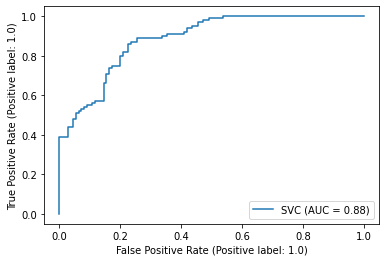

MLPClassifier(alpha=1e-06, learning_rate_init=0.0031622776601683794,
              random_state=2021)
[MLPClassifier] Acc Test: 0.5810


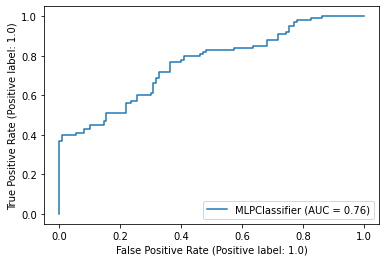

ExtraTreesClassifier(bootstrap=True, ccp_alpha=0.0031980994152046795,
                     max_depth=25, n_estimators=300, random_state=2021)
[ExtraTreesClassifier] Acc Test: 0.5810


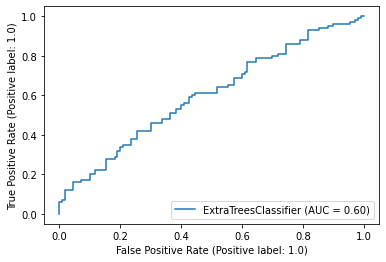

GradientBoostingClassifier(learning_rate=1.0, n_estimators=300,
                           random_state=2021)
[GradientBoostingClassifier] Acc Test: 0.6143


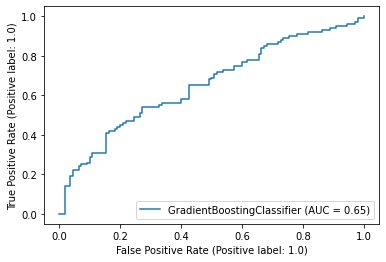

In [15]:
from sklearn.metrics import plot_roc_curve
for clf in best_models:
    name = clf['clf'].__class__.__name__
    acc_test = clf.score(X_test, y_test)
    print(clf['clf'])
    print(f"[{name}] Acc Test: {acc_test:.4f}")
    plot_roc_curve(clf, X_test, y_test, name=name)
    plt.show()